Code for paper A. Bouchnita and V. Volpert. "Intracellular ISG-virus interactions determine viral infection severity and persistence"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
dt = 0.001             # space step
Nt = 30                # number of days
TTT = np.linspace(0, Nt, int(Nt/dt) + 1)   # time vector

L = 1                  # virus interval length
dx = 0.05              # virus interval step
XX = np.linspace(dx, 0 + L + 2*dx, int(L/dx) + 3)     # virus vector [dx, L + 2dx]

M = 1                  # ISGs interval length
dy = 0.05              # ISGs step

YY = np.linspace(-dy, dy + M, int(M/dy) + 3)          # ISGs vector [-dx, L + dx]

In [31]:
#vectors for virus and ISG secretion
ab = np.zeros([int(L/dx) + 3, int(M/dy) + 3])
ac = np.zeros([int(L/dx) + 3, int(M/dy) + 3])

for i in range(int(L/dx) + 3):
    for j in range(int(M/dy) + 3):
        ab[i,j] = XX[i]
        ac[i,j] = (1-YY[j])

# integral calculation function
def integral_of_vector(x, y):
    if len(x) != len(y):
        raise ValueError("Vectors x and y must have the same length.")
    return np.trapz(y, x)

In [32]:
# fixed parameters, refer to Table 1 of the manuscript
k1 = 1*4e-6            # healthy cell recovery
mu1 = 1
sigma = 2      
k4 = 1
k6 = 1
gamma = 1.2

V0 = 100
C0 = 4e5


def simulate(rho, alpha, beta, K1, K2, mu2, k2, V0, gamma, k3, k5):
    # initial
    C = C0
    C_n = 0

    V = V0
    V_n = 0
    
    I = 0
    I_n = 0
    
    Cn_daily = []  # List to store Cn arrays
    V_daily = []   # List to store V values
    I_daily = []   # List to store I values
    C_daily = []
    times = []

    LL = 0.2
    Cn = np.zeros([int(L/dx) + 3, int(M/dy) + 3])
    Cn_n = np.zeros([int(L/dx) + 3, int(M/dy) + 3])

    
    Cn_daily.append(Cn.copy())  # Save a copy of the current Cn
    V_daily.append(V)          # Save the current V
    I_daily.append(I)   
    C_daily.append(C) 
    times.append(0)
    
    def integral_of_2D_vector(XX, YY, vector):
        dx = XX[1] - XX[0]  # Assuming uniform grid
        dy = YY[1] - YY[0]
        return np.sum(vector) * dx * dy
    
    # Define function for computing integrals in specific regions
    def integral_of_2D_region(XX, YY, vector, x_min, x_max, y_min, y_max):
        dx = XX[1] - XX[0]  # Assuming uniform grid
        dy = YY[1] - YY[0]
        
        mask = (XX[:, None] >= x_min) & (XX[:, None] <= x_max) & (YY[None, :] >= y_min) & (YY[None, :] <= y_max)
        return np.sum(vector[mask]) * dx * dy
    
    # Initialize separate vectors for storing integrals
    Cn_total_daily = []
    Cn_00_05_00_05_daily = []
    Cn_05_10_00_05_daily = []
    Cn_00_05_05_10_daily = []
    Cn_05_10_05_10_daily = []
    Cn_total_daily.append(integral_of_2D_vector(XX, YY, Cn))
    
    #print(integral_of_vector(YY, phi_c[0,:]))
    
    for tt in range(int(Nt/dt) + 1):
        C_n = C + dt*(k1*(C0-C) - k2*V*C)

        for j in range(0,int(M/dy)+2):

            for i in range(2,int(L/dx)+2):

                if (YY[j]  >= 0 and YY[j] <= 0 + LL and XX[i] <= 0.15 and XX[i] >= 0):
                    Cn_n[i, j] = Cn[i, j] + dt * (
                        +  k2*V*C/(LL*0.15) 
                        - (alpha*(1-XX[i])/ (1 + K1 * YY[j])) * (Cn[i, j] - Cn[i - 1, j]) / dx + alpha*Cn[i,j]/(1 + K1 * YY[j])              # replication 1
                        - (beta * I * (1 - YY[j - 1]) / (1 + K2 * XX[i])) * (Cn[i, j] - Cn[i, j - 1]) / dy  + beta*I*Cn[i,j]/(1 + K2 * XX[i])                                 # IFN response
                        + mu1 * XX[i]* (Cn[i + 1, j] -  Cn[i, j]) / dx  + mu1*Cn[i,j]                                                      # virus decay
                        + rho *  (1 - YY[j]) * XX[i]* (Cn[i + 1, j] - Cn[i, j]) / dx + rho*(1-YY[j])*Cn[i,j]                  # virus secretion
                        + mu2 * YY[j + 1] * (Cn[i, j + 1] - Cn[i, j]) / dy + mu2*Cn[i,j]                                                       # IFN inactivation
                        - sigma * Cn[i, j]
                        - gamma * XX[i] * YY[j] * Cn[i, j]
                    )
                else:              
                    Cn_n[i, j] = Cn[i, j] + dt * (      
                        - (alpha*(1-XX[i])/ (1 + K1 * YY[j])) * (Cn[i, j] - Cn[i - 1, j]) / dx + alpha*Cn[i,j]/(1 + K1 * YY[j])                # replication 2
                        - (beta * I * (1 - YY[j - 1]) / (1 + K2 * XX[i])) * (Cn[i, j] - Cn[i, j - 1]) / dy + beta*I*Cn[i,j]/(1 + K2 * XX[i])       # IFN response
                        + mu1 * XX[i]* (Cn[i + 1, j] -  Cn[i, j]) / dx  + mu1*Cn[i,j]                                # virus decay
                        + rho *  (1 - YY[j]) * XX[i]* (Cn[i + 1, j] - Cn[i, j]) / dx + rho*(1-YY[j])*Cn[i,j]                       # virus secretion
                        + mu2 * YY[j + 1] * (Cn[i, j + 1] - Cn[i, j]) / dy + mu2*Cn[i,j]                                   # IFN inactivation
                        - sigma * Cn[i, j]
                        - gamma * XX[i] * YY[j] * Cn[i, j]
                    )
        
        V_n = V + dt*(k3*integral_of_2D_vector(XX, YY, rho*ac*ab*Cn) - k4*V)
        I_n = I + dt*(k5*integral_of_2D_vector(XX, YY, ab*Cn) - k6*I)
    
        C = C_n
        Cn = Cn_n
        V = V_n
        I = I_n
    
        if tt % int(0.5 / dt) == 0:  # Check if a day has passed
            Cn_daily.append(Cn.copy())  # Save a copy of the current Cn
            V_daily.append(V)          # Save the current V
            I_daily.append(I)    
            C_daily.append(C)
            times.append(tt*dt)
    
    
            Cn_total_daily.append(integral_of_2D_vector(XX, YY, Cn))
            Cn_00_05_00_05_daily.append(integral_of_2D_region(XX, YY, Cn, 0, 0.5, 0, 0.5))
            Cn_05_10_00_05_daily.append(integral_of_2D_region(XX, YY, Cn, 0.5, 1, 0, 0.5))
            Cn_00_05_05_10_daily.append(integral_of_2D_region(XX, YY, Cn, 0, 0.5, 0.5, 1))
            Cn_05_10_05_10_daily.append(integral_of_2D_region(XX, YY, Cn, 0.5, 1, 0.5, 1))

    return times, C_daily, V_daily, I_daily, Cn_daily, Cn_total_daily, Cn_00_05_00_05_daily, Cn_05_10_00_05_daily, Cn_00_05_05_10_daily, Cn_05_10_05_10_daily

In [33]:
times, C_daily1, V_daily1, I_daily1, Cn_daily1, Cn_total_daily1, Cn_00_05_00_05_daily1, Cn_05_10_00_05_daily1, Cn_00_05_05_10_daily1, Cn_05_10_05_10_daily1 = simulate(0.56, 2.7725, 5e-7, 4, 4, 1, 0.08e-5, 0.05, 2, 1900, 500)


In [34]:
X = [1, 4,   5,   8,   14,  19,  21]
Y = [1, 6, 6.9, 5.9, 3.2, 1, 0]

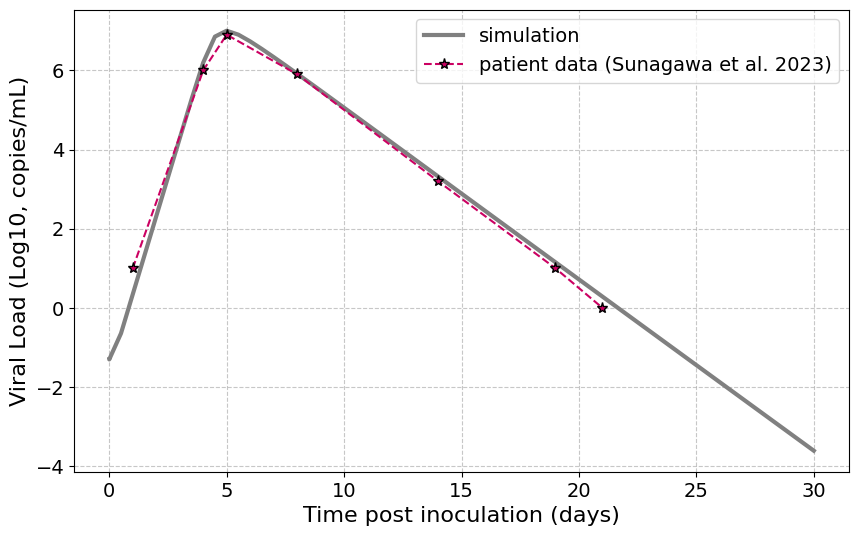

In [36]:

plt.figure(figsize=(10, 6))  # Adjust the figure size (width, height) in inches

plt.plot(times, np.log10(V_daily1), color = 'gray', label=r"simulation", linewidth=3)
# plt.plot(times, np.log10(V_daily2), label=r"$\beta = 2 \times 10^{-4} \; mL/(pg.day)$", color="xkcd:deep pink", linewidth=2)
plt.plot(X, Y, '--*', label='patient data (Sunagawa et al. 2023)', color="xkcd:deep pink", markersize=8, markeredgecolor="black") 
#plt.plot(times, np.log10(V_daily2), color = 'blue', label=r"simulation", linewidth=3)


# Add labels, title, and grid
plt.xlabel("Time post inoculation (days)", fontsize=16)
plt.ylabel("Viral Load (Log10, copies/mL)", fontsize=16)
# plt.title("Comparison of Viral Load Over Time", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)  # Dashed grid lines with transparency
#plt.axis([0, 20, 2, 8])

# Increase tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.savefig('viral_load.png', dpi=300)  # Save with higher resolution

# Show plot
plt.show()

In [27]:
def find_peak(V_daily):
    """
    Finds the peak (maximum value) in a given vector and its corresponding time index.
    
    Parameters:
    V_daily (list or numpy array): The input vector containing time-series data.
    
    Returns:
    tuple: (peak_value, peak_time) where peak_value is the max value and peak_time is its index.
    """
    peak_value = np.max(V_daily)  # Maximum value in V_daily
    peak_time = np.argmax(V_daily)  # Index where the max value occurs
    
    return integral_of_vector(times, V_daily), peak_value, peak_time/2, np.log10(V_daily[61])

# Example usage (replace with actual V_daily1 data)
AUC, peak_value, peak_time, last_val = find_peak(V_daily1)

print(f"Peak Value: {peak_value}, Integral: {AUC}, Peak Time: {peak_time}, last_val: {last_val}")

Peak Value: 9817814.760248309, Integral: 20164005.91143727, Peak Time: 5.5, last_val: -3.5931599604438835


In [ ]:
# Sensitivity analysis

base_parameters = np.zeros([11, ])
base_parameters[0] = 0.56       # k3 secretion rate            
base_parameters[1] = 2.7725     # k4 replication rate
base_parameters[2] = 5e-6       # k5 ISG activation rate
base_parameters[3] = 4          # K2 ISG inhibition of virus replication
base_parameters[4] = 4          # K3 virus inhibition of ISG activation
base_parameters[5] = 1          # k7 ISG downregulation
base_parameters[6] = 9e-7       # beta infection rate
base_parameters[7] = 0.05       # V0 initial virus inoculation
base_parameters[8] = 2          # k13 cell death by caspase
base_parameters[9] = 1900       # k9 virus production rate
base_parameters[10] = 500       # k11 IFN production rate

AUC_20p = np.zeros([11, ])
peakV_20p = np.zeros([11, ])
peakt_20p = np.zeros([11, ])

for i in range(11):
    new_parameters = base_parameters.copy()
    new_parameters[i] = base_parameters[i] + 0.2 * base_parameters[i]
    
    times, C_daily1, V_daily2, I_daily1, Cn_daily1, Cn_total_daily1, \
    Cn_00_05_00_05_daily1, Cn_05_10_00_05_daily1, \
    Cn_00_05_05_10_daily1, Cn_05_10_05_10_daily1 = simulate(
        new_parameters[0], new_parameters[1], new_parameters[2],
        new_parameters[3], new_parameters[4], new_parameters[5],
        new_parameters[6], new_parameters[7], new_parameters[8],
        new_parameters[9], new_parameters[10]
    )

    AUC1, peak_value1, peak_time1, last_val1 = find_peak(V_daily2)

    AUC_20p[i] = AUC1
    peakV_20p[i] = peak_value1
    peakt_20p[i] = peak_time1


times, C_daily1, V_daily3, I_daily1, Cn_daily1, Cn_total_daily1, \
Cn_00_05_00_05_daily1, Cn_05_10_00_05_daily1, \
Cn_00_05_05_10_daily1, Cn_05_10_05_10_daily1 = simulate(
    base_parameters[0], base_parameters[1], base_parameters[2],
    base_parameters[3], base_parameters[4], base_parameters[5],
    base_parameters[6], base_parameters[7], base_parameters[8],
    base_parameters[9], base_parameters[10]
)

AUC, peak_value, peak_time, last_val = find_peak(V_daily3)


In [ ]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(6, 6)) 

# LaTeX-formatted parameter symbols
X_axis = ['\\rho', '\\alpha', '\\beta', 'K_1', 'K_2', '\\mu_2', 'k_2', 'V_0', '\\gamma', 'k_3', 'k_5']
x_labels = [f"${x}$" for x in X_axis]

# Numeric positions on the x-axis
x_positions = list(range(len(X_axis)))

# Plot with circles instead of a line
plt.plot(x_positions, AUC_20p/AUC, marker='o', linestyle='None', label='AUC (20% increase)')

# Add horizontal line at the average AUC
plt.axhline(AUC/AUC, color='red', linestyle='--')

# Apply LaTeX labels to the x-axis
plt.xticks(ticks=x_positions, labels=x_labels)

# Labels and formatting
plt.xlabel('20% increase in parameter')
plt.ylabel('Area under the curve')
#plt.title('Sensitivity Analysis')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('AUC_sensitivity.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# LaTeX-formatted parameter symbols
X_axis = ['\\rho', '\\alpha', '\\beta', 'K_1', 'K_2', '\\mu_2', 'k_2', 'V_0', '\\gamma', 'k_3', 'k_5']
x_labels = [f"${x}$" for x in X_axis]

# Numeric positions on the x-axis
x_positions = list(range(len(X_axis)))

# Plot with circles instead of a line
plt.plot(x_positions, peakV_20p/peak_value, marker='o', linestyle='None')

# Add horizontal line at the average AUC
plt.axhline(peak_value/peak_value, color='red', linestyle='--')

# Apply LaTeX labels to the x-axis
plt.xticks(ticks=x_positions, labels=x_labels)

# Labels and formatting
plt.xlabel('20% increase in parameter')
plt.ylabel('Peak value')
#plt.title('Sensitivity Analysis')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('peak_sensitivity.png')
plt.show()
